In [1]:
# PyTorch and PyTorch Geometric imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import from_networkx

# NetworkX imports
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# Other imports
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import random

# Custom imports
from Datasets.synthetics import BA_2grid, BA_2grid_house, ProbingDataset, BA_2grid_to_test
from models.models_BA_2grid import GIN_framework as framework

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(37)

Model

In [5]:
MODEL = "GCN"
DATASET = "BA_2grid_house"

# import the model
from models.models_BA_2grid_house import GCN_framework as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house

In [6]:
# inizialize the framework
dataset = BA_2grid_house()
gnn = framework(dataset,device="cpu")

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
#dataset length
len(dataset)

2000

In [8]:
# the gnn object contains the train test split and the model.

print(gnn.model)
print(gnn.train_idx)
print(gnn.dataset[gnn.train_idx])

Net(
  (conv1): GCNConv(10, 60)
  (conv2): GCNConv(60, 60)
  (conv3): GCNConv(60, 60)
  (conv4): GCNConv(60, 60)
  (lin1): Linear(in_features=60, out_features=60, bias=True)
  (lin2): Linear(in_features=60, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=2, bias=True)
)
tensor([ 701, 1225,   47,  ...,   40,  423,  494])
BA_2grid_house(1600)


In [9]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL)
print("we loaded the weights")
# right now the model has trained weights.
#print(gnn.model.mlp1.weight[0])

we loaded the weights


In [11]:
# train the model
gnn.evaluate()

Test Loss: 0.029, Train Acc: 0.971 Test Acc: 0.965


properties of the graphs

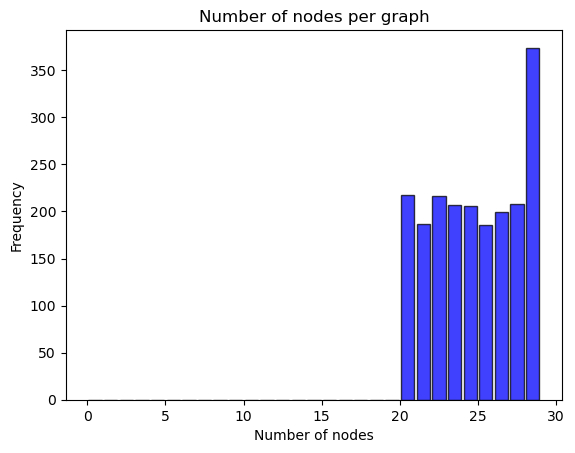

(20, 29)

In [11]:
#pritn the distribution of the number of nodes per graph in the dataset

# number of nodes per graph
nodes = [len(graph.x) for graph in dataset]
plt.hist(nodes, bins=range(0, max(nodes)+1, 1), alpha=0.75, rwidth=0.85, color='b', edgecolor='black')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.title('Number of nodes per graph')
plt.show()

#print the min and max number of nodes in the dataset
min(nodes), max(nodes)

In [ ]:
def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_nodes_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_nodes_in_the_largest_fully_connected_component, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

In [ ]:
print(train_properties[0:3])
print(test_properties[0:3])

In [ ]:
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties_special.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties_special.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

In [12]:
#open the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_special.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_special.pkl", "rb") as f:
    test_properties = pkl.load(f)

### Probing pipeline 

from extracting features to training a diagnostic classifier

In [13]:
"""
train_features and test_features are lists of lists. Each element correspond to a graph, each graph has 4 layers of features, and each features has a shape of (num_nodes, num_features) where each row is a node and each column is a feature. 
To probe our model we will use the four different layers and probe for node properties based on their corresponding row in the feature matrix.
"""
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=False)

In [14]:
len(train_features[0])

8

In [15]:
len(train_features), len(test_features)

(1600, 400)

##### Testes of different posibilities

In [ ]:
#check if the gnn.dataset[gnn.train_idx] is the same as the one in the dataset to check if the split is reproducible

# let's create the train and test loaders from dataset
idx = torch.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=dataset.data.y,random_state=10)

train_loader = DataLoader(dataset[train_idx],batch_size=256)
test_loader = DataLoader(dataset[test_idx],batch_size=256)

# let's check if the loaders are the same as the one in the gnn object
for i, (data) in enumerate(train_loader):
    print(data)
    print(gnn.dataset[gnn.train_idx[i]])
    if i == 3: 
        break


In [ ]:
# save gnn.dataset[gnn.train_idx] and gnn.dataset[gnn.test_idx] in a file
with open("models/"+DATASET+"_"+MODEL+"_train.pkl", "wb") as f:
    pkl.dump(gnn.dataset[gnn.train_idx], f)

with open("models/"+DATASET+"_"+MODEL+"_test.pkl", "wb") as f:
    pkl.dump(gnn.dataset[gnn.test_idx], f)

In [ ]:
# load the data
with open("models/"+DATASET+"_"+MODEL+"_train.pkl", "rb") as f:
    train_data = pkl.load(f)

In [ ]:
# Evaluate to get features
train_features, test_features = gnn.evaluate_with_features2()

# Extract x_global and x_lin1 embeddings for training set
train_x_global = np.array([feat[0] for feat in train_features])
train_x_lin1 = np.array([feat[1] for feat in train_features])

#take only the first 10 elements
# train_x_global = train_x_global[:10]
# train_x_lin1 = train_x_lin1[:10]

# Extract x_global and x_lin1 embeddings for test set
test_x_global = np.array([feat[0] for feat in test_features])
test_x_lin1 = np.array([feat[1] for feat in test_features])

#take only the first 10 elements
# test_x_global = test_x_global[:10]
# test_x_lin1 = test_x_lin1[:10]


In [ ]:
#print the number of embeddings for the train and test set
print(len(train_x_global), len(train_x_lin1), len(test_x_global), len(test_x_lin1))

linear regression

In [ ]:
import numpy as np

# Prepare training data
train_x = train_x_global  # or use train_x_lin1 if you prefer
train_y = np.array(train_properties)

# Prepare testing data
test_x = test_x_global  # or use test_x_lin1 if you prefer
test_y = np.array(test_properties)


In [ ]:
# Train a regression model for each graph property
models = []
for i in range(train_y.shape[1]):
    model = LinearRegression()
    model.fit(train_x, train_y[:, i])
    models.append(model)

# Evaluate the models
for i, model in enumerate(models):
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)
    
    train_mse = mean_squared_error(train_y[:, i], train_pred)
    test_mse = mean_squared_error(test_y[:, i], test_pred)
    
    print(f'Property {i}: Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}')


Linear model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


In [ ]:
# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)


In [ ]:
len(train_x)

In [ ]:
train_y[:, 4]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features()

# Extract x_global embeddings
train_x_global = np.array([feat[0] for feat in train_features])
test_x_global = np.array([feat[0] for feat in test_features])

# Extract 5th, 6th and 7th embeddings
train_x5 = np.array([feat[1] for feat in train_features])
test_x5 = np.array([feat[1] for feat in test_features])

train_x6 = np.array([feat[2] for feat in train_features])
test_x6 = np.array([feat[2] for feat in test_features])

train_x7 = np.array([feat[3] for feat in train_features])
test_x7 = np.array([feat[3] for feat in test_features])

# Compute graph properties
train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)



# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques']
""" 
for i, property_name in enumerate(property_names):
    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(train_x).squeeze()  # Ensure outputs is the correct shape
        target = train_y[:, i].squeeze()  # Ensure target is the correct shape

        # Debugging information
        #print(f"Epoch [{epoch+1}/{num_epochs}], Property: {property_name}")
        #print(f"outputs shape: {outputs.shape}, target shape: {target.shape}")

        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_pred = model(train_x).squeeze().cpu().numpy()
        test_pred = model(test_x).squeeze().cpu().numpy()
        
        train_target = train_y[:, i].cpu().numpy()
        test_target = test_y[:, i].cpu().numpy()
        
        train_mse = mean_squared_error(train_target, train_pred)
        test_mse = mean_squared_error(test_target, test_pred)
        
        train_r2 = r2_score(train_target, train_pred)
        test_r2 = r2_score(test_target, test_pred)
        
        print(f'Property: {property_name}')
        print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
        print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}') """

# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']

embeddings = [train_x, train_x5, train_x6, train_x7]

for embedding in embeddings:
    # Train and evaluate a model for each graph property
    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(embedding).squeeze().cpu().numpy()
            test_pred = model(test_x).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


### Diagnostic classifier

In [16]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x_global, x5, x6, x7)
"""

output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x_global = np.array([feat[4] for feat in train_features])
test_x_global = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']

In [17]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save the results in a file
# with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
#     pkl.dump(results, f)

Epoch [1000/10000], Property: num_nodes, Loss: 492.1789
Epoch [2000/10000], Property: num_nodes, Loss: 394.6215
Epoch [3000/10000], Property: num_nodes, Loss: 311.5204
Epoch [4000/10000], Property: num_nodes, Loss: 241.3055
Epoch [5000/10000], Property: num_nodes, Loss: 182.9350
Epoch [6000/10000], Property: num_nodes, Loss: 135.6196
Epoch [7000/10000], Property: num_nodes, Loss: 98.5746
Epoch [8000/10000], Property: num_nodes, Loss: 70.8202
Epoch [9000/10000], Property: num_nodes, Loss: 51.0955
Epoch [10000/10000], Property: num_nodes, Loss: 37.5669
Embedding: torch.Size([1600, 60])
Property: num_nodes
  Train MSE: 37.5558, Test MSE: 35.5192
  Train R²: -3.5475, Test R²: -3.4135
Epoch [1000/10000], Property: num_edges, Loss: 655.1074
Epoch [2000/10000], Property: num_edges, Loss: 540.4961
Epoch [3000/10000], Property: num_edges, Loss: 440.5933
Epoch [4000/10000], Property: num_edges, Loss: 353.9026
Epoch [5000/10000], Property: num_edges, Loss: 279.4684
Epoch [6000/10000], Property: n

In [31]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

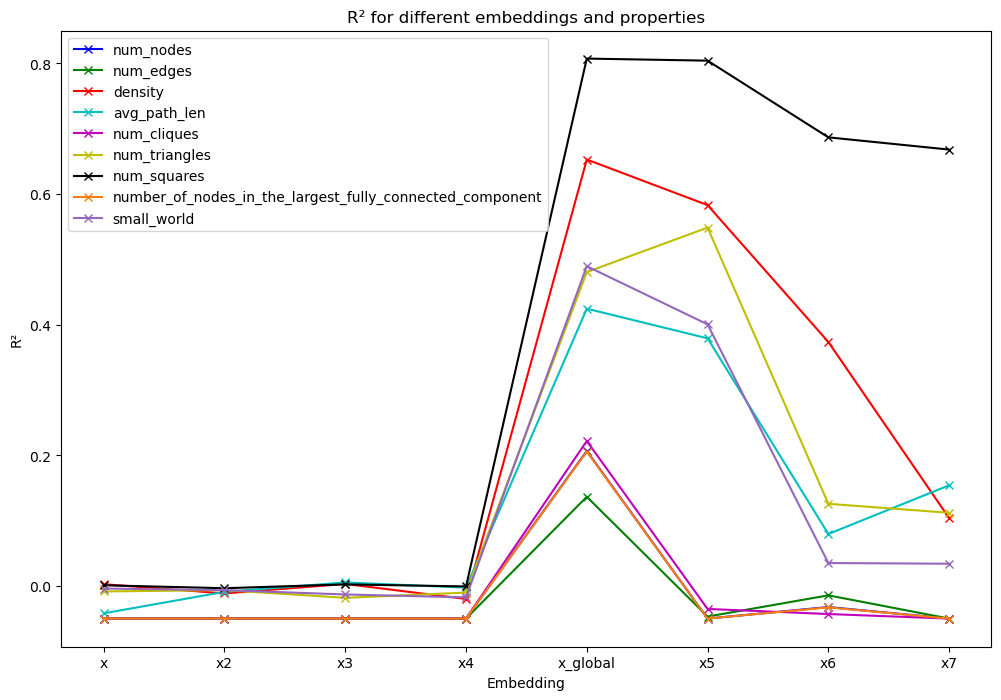

In [18]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()


### Node embedding probing

This time we will try to probe for node embedding learnt representations. What would make sense is that the GNN uses some node characteristics like the betweeness centrality of some nodes to predict if a graph could contain both a grid and a house. 

##### Node properties

In [28]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [29]:
len(train_node_properties), len(test_node_properties)

(1600, 400)

In [14]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(3)]

[25, 27, 27]

In [15]:
#We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
# is equal to the length of the x matrix in the features. 


([6, 3, 1, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 3, 2, 3, 3, 2, 3, 3, 2, 4, 3, 2, 3, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0.3333333333333333, 1.0, 0, 0, 0, 0, 0, 0, 0, 0], [0.5333333333333333, 0.15666666666666668, 0.0, 0.68, 0.0, 0.08, 0.0, 0.0, 0.0, 0.48000000000000004, 0.33333333333333337, 0.45777777777777784, 0.0, 0.2816666666666667, 0.03666666666666667, 0.11, 0.005, 0.0, 0.18666666666666665, 0.18666666666666665, 0.03277777777777778, 0.1488888888888889, 0.045000000000000005, 0.03277777777777778, 0.045000000000000005, 0.0044444444444444444], [0.10521234016833964, 0.048588000626310864, 0.03673891466296968, 0.1006609369854998, 0.03673891466296968, 0.041840717455278266, 0.03673891466296968, 0.016966456417454732, 0.016966456417454732, 0.13788238057672458, 0.04518201359998669, 0.29421941246853595, 0.014610350065082807, 0.028731959419011167, 0.016198792919026577, 0.020900550098289828, 0.017656811386470742, 0.013464259755574791, 0.3523681982355651, 0.352368198235565

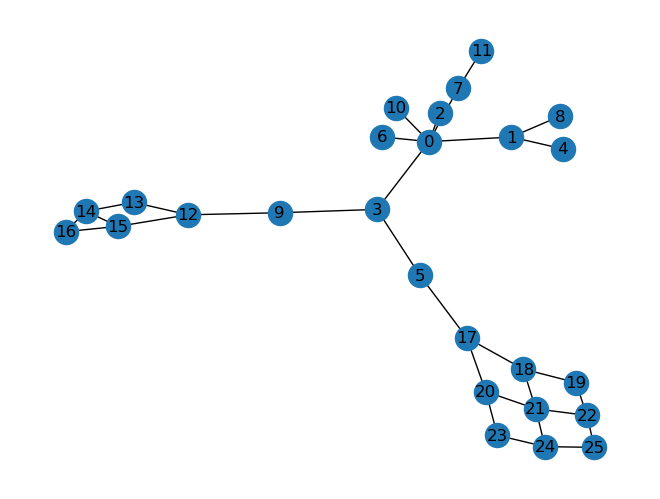

In [16]:
#visualise the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[gnn.test_idx][0].edge_index.t().tolist())
nx.draw(G, with_labels=True)

#print the properties of the first graph
print(test_node_properties[0])

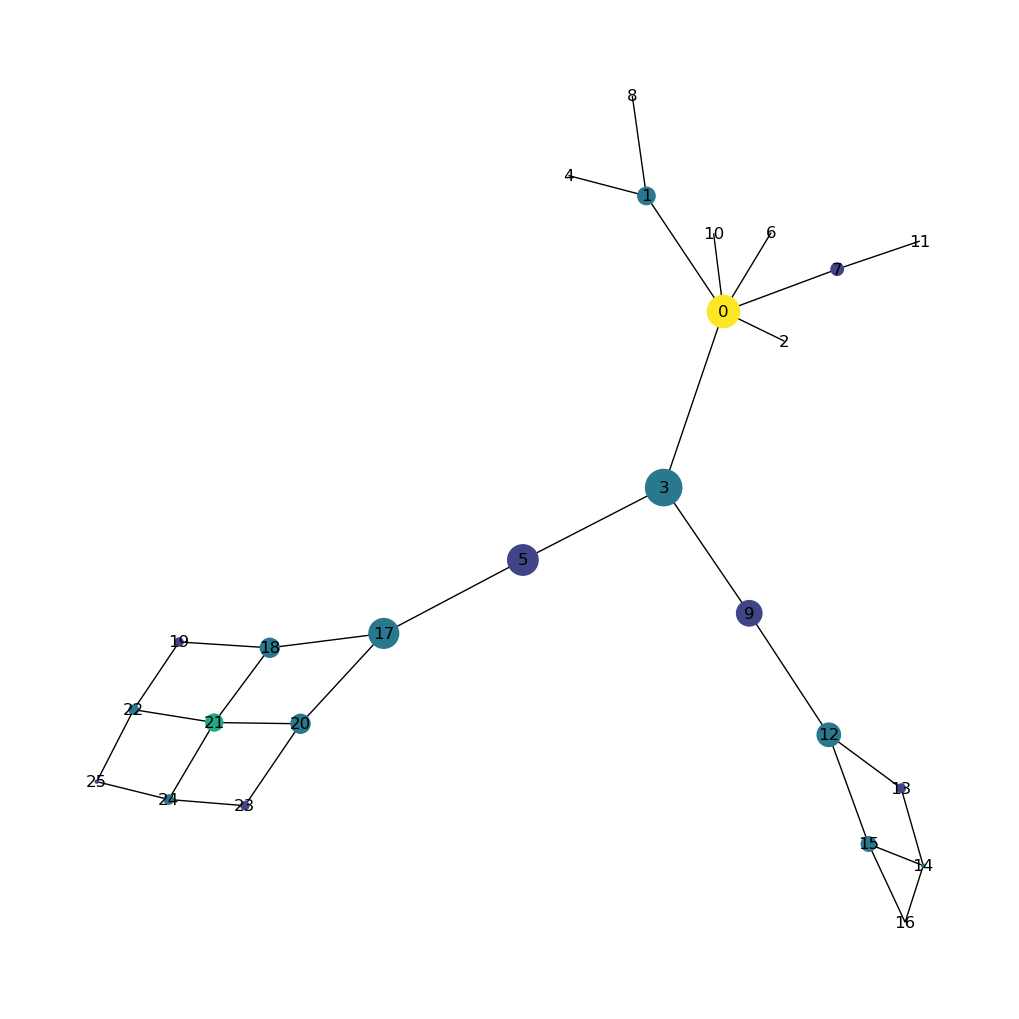

In [17]:
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


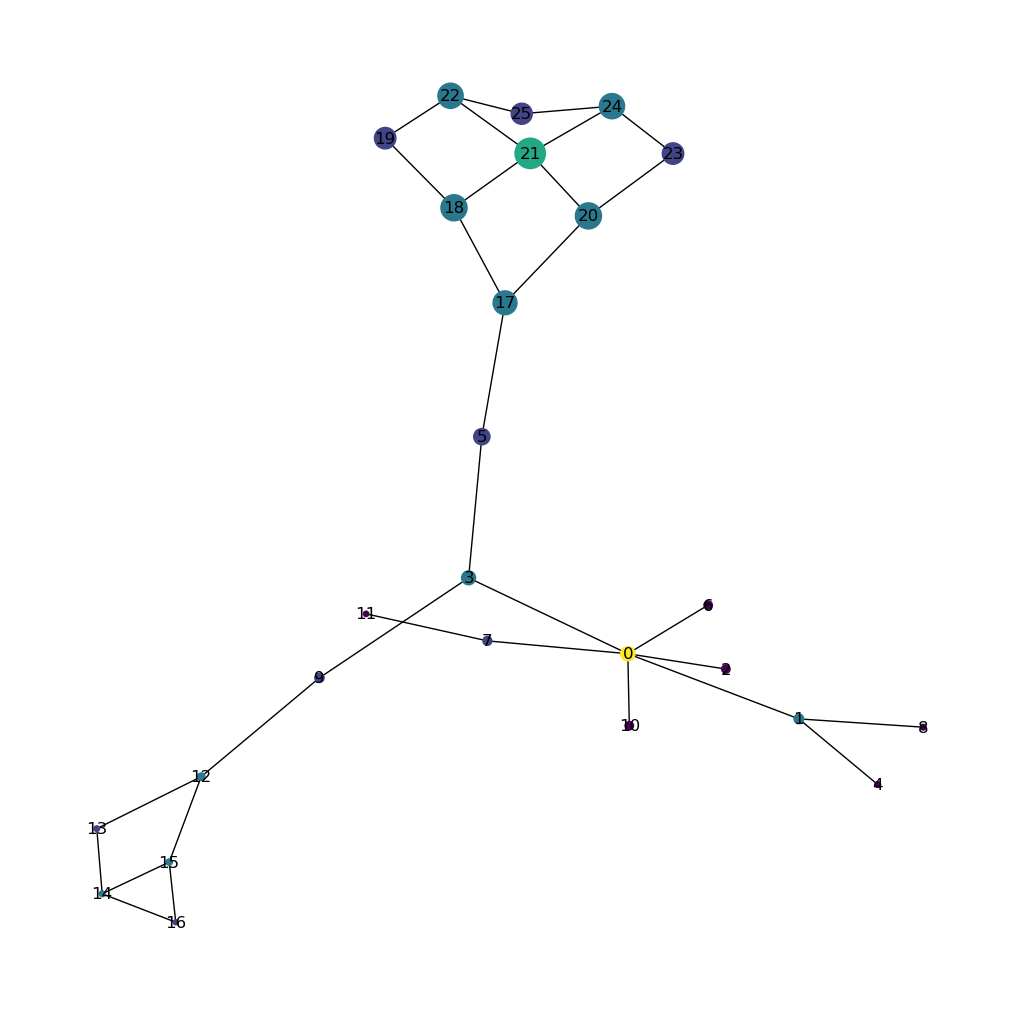

In [18]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

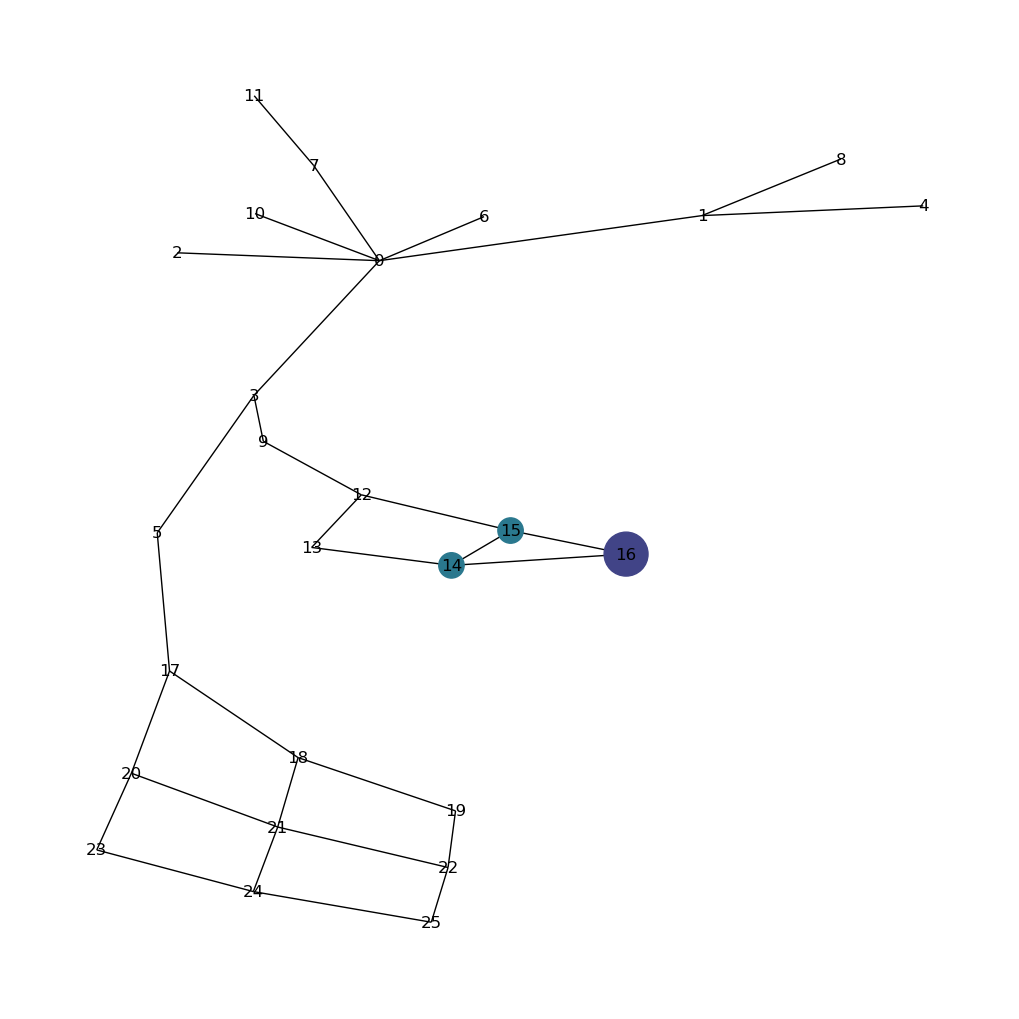

In [19]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

Hypothesis : it would make a lot of sense for the GNN to use both the node propeties of local clustering coefficient and eigenvector centrality. The interesting thing is that these two features individually are not enough to render the problem linearly separable. It would thus make sense to use both of these properties and combine them. At the end, the problem makes more sense to be solved in a global property fashion with the number of squares. 
But if it makes sense to use these node properties for the classification of the double presence of grid and house, then we should be able to probe them in the node embeddings. In other words, if we can rpedict some node-level property on the corresponding vector embeddings of the GNN for a given classification problem, then it should mean that these properties are useful for the problem resolution.

For example, if the local clustreing coefficient of a node is an important feature for prediciton, we should then see that we can consistently preidct it throught the layers for graphs. We could try for both the node of interest (first find the node of interest (the max value), then its position and probe only for the corresponding vector). The given prediction score would be a good indicator of the use of this property *and* we could give a designed graph that shows the relation between the property values and the ability to predict it. Or for all the nodes (even those with a value of 0 for example), and present the average score as a good indicator (meaning that it's important for the GNN to be able to predict when the property is not here. That's also something that could work). 

We have our node embeddings (Train and test features) are lists of lists. Each element correspond to a graph, each graph has 8 layers of features, and each features has a shape of (num_nodes, num_features) where each row is a node and each column is a feature. As a consequence the number of nodes in the graph is changing for each graph.

Same with node_properties, train and test_node_properties are lists of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph. 

Because they have the same inconsistencies (graph are presented in the same order and thus if the first one has 24 nodes and the second 27, both embeddings and properties will correspond), then we can have a probe one by one.

##### Node embeddings

In [10]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

x1 shape: torch.Size([25, 60])
x2 shape: torch.Size([25, 60])
x3 shape: torch.Size([25, 60])
x4 shape: torch.Size([25, 60])
len of features:  4
features[0].shape:  torch.Size([25, 60])
features[1].shape:  torch.Size([25, 60])
features[2].shape:  torch.Size([25, 60])
features[3].shape:  torch.Size([25, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])


In [11]:
len(train_features), len(test_features)

(1600, 400)

In [18]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (27, 60)
Feature 2 shape: (27, 60)
Feature 3 shape: (27, 60)
Feature 4 shape: (27, 60)


In [22]:
train_features[1][0][26]

array([0.11293012, 0.01297014, 0.        , 0.        , 0.00048169,
       0.        , 0.        , 0.11032721, 0.0006601 , 0.        ,
       0.        , 0.00569319, 0.01119991, 0.        , 0.        ,
       0.        , 0.        , 0.1187728 , 0.02496059, 0.        ,
       0.        , 0.        , 0.09984584, 0.        , 0.16730181,
       0.12269668, 0.        , 0.        , 0.13658862, 0.        ,
       0.        , 0.        , 0.        , 0.02736452, 0.        ,
       0.        , 0.        , 0.01627633, 0.        , 0.00716374,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11217522, 0.00050629, 0.        , 0.04717182,
       0.11243994, 0.        , 0.        , 0.        , 0.06470888,
       0.        , 0.        , 0.        , 0.        , 0.        ])

#### Embedding probing

In [58]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=3):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [59]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 3) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 3) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [60]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [69]:

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')


R² for local clustering coefficient prediction: [0.4841927549025531, 0.5885748736985221, 0.553935958537314, 0.5937347910192293]
R² for eigenvector centrality prediction: [0.4159696190840295, 0.4910735740692913, 0.5317800215207991, 0.5328035947641372]
R² for node degree prediction: [0.79121277530391, 0.813389031323898, 0.7947223264111095, 0.805799508393025]
R² for betweenness centrality prediction: [0.49523594279566274, 0.53993553609594, 0.5741994943077879, 0.5884060368158552]


In [71]:
# probing for the top 3 nodes in the test set for all the graphs and all the layers and plot the results. Do it for node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients

# Get the top 3 nodes for node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients
top_nodes_node_degrees = [get_top_nodes(graph_props[0], 3) for graph_props in test_node_properties]
top_nodes_clustering_coeffs = [get_top_nodes(graph_props[1], 3) for graph_props in test_node_properties]
top_nodes_betweenness = [get_top_nodes(graph_props[2], 3) for graph_props in test_node_properties]
top_nodes_eigenvector = [get_top_nodes(graph_props[3], 3) for graph_props in test_node_properties]
top_nodes_Local_clustering_coefficients = [get_top_nodes(graph_props[4], 3) for graph_props in test_node_properties]



400

In [62]:
# To perform the same for all nodes, simply do not filter by top_nodes_indices in prepare_regression_data function
def prepare_regression_data_all_nodes(features, properties):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in range(len(graph_features[layer])):
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Prepare data for all nodes for local clustering coefficient
X_local_clustering_all, y_local_clustering_all = prepare_regression_data_all_nodes(train_features, [props[3] for props in train_node_properties])

# Train and evaluate model for local clustering coefficient for all nodes
r2_local_clustering_all = train_and_evaluate_regression(X_local_clustering_all, y_local_clustering_all)
print(f'R² for local clustering coefficient prediction (all nodes): {r2_local_clustering_all}')

# Prepare data for all nodes for eigenvector centrality
X_eigenvector_all, y_eigenvector_all = prepare_regression_data_all_nodes(train_features, [props[4] for props in train_node_properties])

# Train and evaluate model for eigenvector centrality for all nodes
r2_eigenvector_all = train_and_evaluate_regression(X_eigenvector_all, y_eigenvector_all)
print(f'R² for eigenvector centrality prediction (all nodes): {r2_eigenvector_all}')

Epoch 0, Loss: 0.043427061289548874
Epoch 10, Loss: 0.016707057133316994
Epoch 20, Loss: 0.015926795080304146
Epoch 30, Loss: 0.01486995816230774
Epoch 40, Loss: 0.014437597244977951
Epoch 50, Loss: 0.014276357367634773
Epoch 60, Loss: 0.014213703572750092
Epoch 70, Loss: 0.014157404191792011
Epoch 80, Loss: 0.01412365585565567
Epoch 90, Loss: 0.014092283323407173
R² for local clustering coefficient prediction (all nodes): 0.14012356640802348
Epoch 0, Loss: 0.0343756340444088
Epoch 10, Loss: 0.028506875038146973
Epoch 20, Loss: 0.027549918740987778
Epoch 30, Loss: 0.027089733630418777
Epoch 40, Loss: 0.027017295360565186
Epoch 50, Loss: 0.026895923539996147
Epoch 60, Loss: 0.026825154200196266
Epoch 70, Loss: 0.026761330664157867
Epoch 80, Loss: 0.02670537494122982
Epoch 90, Loss: 0.0266557689756155
R² for eigenvector centrality prediction (all nodes): 0.03372688862563611


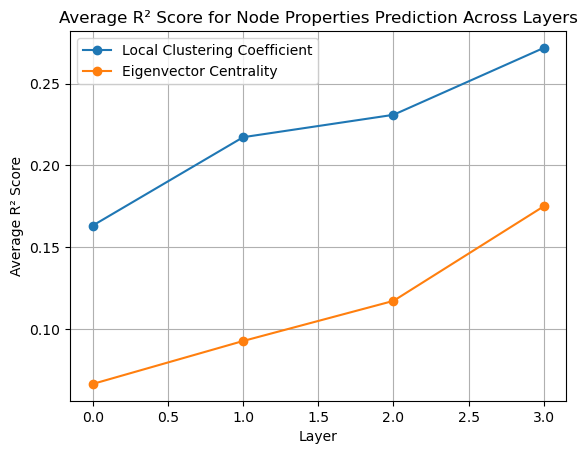

In [68]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices=None):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            if top_nodes_indices:
                for node_index in top_nodes_indices[i]:
                    X_layers[layer].append(graph_features[layer][node_index])
                    y_layers[layer].append(properties[i][node_index])
            else:
                for node_index in range(len(graph_features[layer])):
                    X_layers[layer].append(graph_features[layer][node_index])
                    y_layers[layer].append(properties[i][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Training and evaluating linear regression models for each layer
def train_and_evaluate_regression(X_layers, y_layers):
    r2_scores = []
    
    for layer in range(len(X_layers)):
        X = X_layers[layer]
        y = y_layers[layer]
        
        model = LinearModel(X.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X.float())
            loss = criterion(outputs, y.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(X.float()).view(-1)
            r2 = r2_score(y.float(), predictions)
        r2_scores.append(r2)
    
    return r2_scores


# Prepare data for local clustering coefficient regression
X_local_clustering_layers, y_local_clustering_layers = prepare_regression_data(train_features, [props[3] for props in train_node_properties])

# Train and evaluate model for local clustering coefficient
r2_local_clustering_layers = train_and_evaluate_regression(X_local_clustering_layers, y_local_clustering_layers)

# Prepare data for eigenvector centrality regression
X_eigenvector_layers, y_eigenvector_layers = prepare_regression_data(train_features, [props[4] for props in train_node_properties])

# Train and evaluate model for eigenvector centrality
r2_eigenvector_layers = train_and_evaluate_regression(X_eigenvector_layers, y_eigenvector_layers)

# Plot the results
layers = np.arange(len(r2_local_clustering_layers))
plt.plot(layers, r2_local_clustering_layers, label='Local Clustering Coefficient', marker='o')
plt.plot(layers, r2_eigenvector_layers, label='Eigenvector Centrality', marker='o')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)
plt.show()

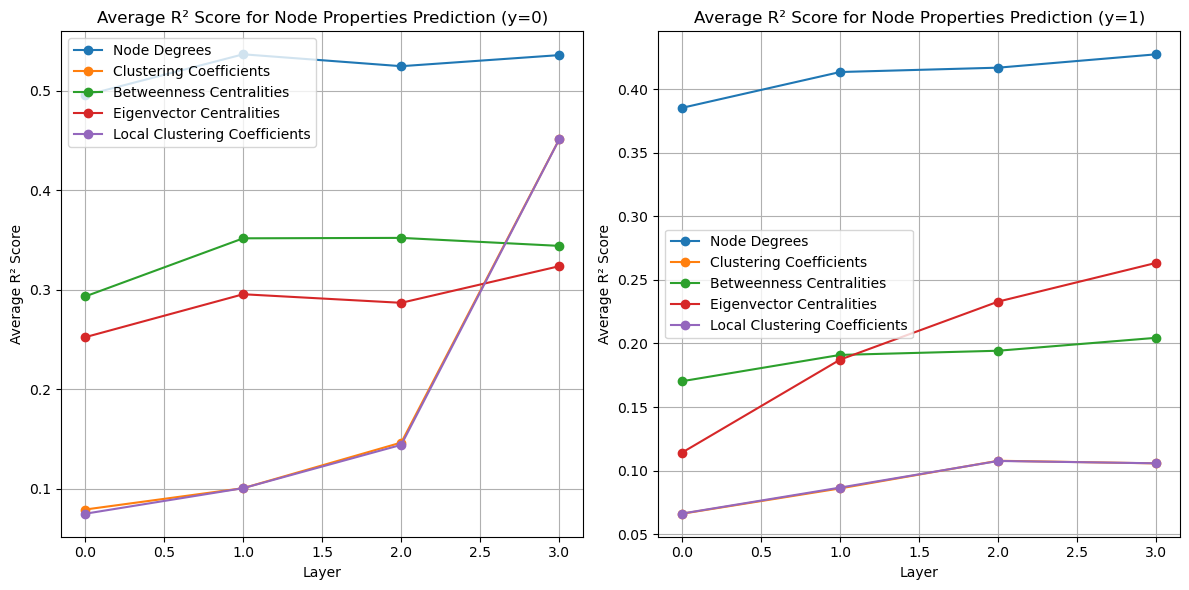

In [67]:
# Separate the graphs based on labels
def separate_graphs_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, graph in enumerate(gnn.dataset[gnn.train_idx]):
        if graph.y.item() == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

train_features_0, train_properties_0, train_features_1, train_properties_1 = separate_graphs_by_label(train_features, train_node_properties, gnn.dataset[gnn.train_idx])

# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, property_index):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in range(len(graph_features[layer])):
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Training and evaluating linear regression models for each layer
def train_and_evaluate_regression(X_layers, y_layers):
    r2_scores = []
    
    for layer in range(len(X_layers)):
        X = X_layers[layer]
        y = y_layers[layer]
        
        model = LinearModel(X.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X.float())
            loss = criterion(outputs, y.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(X.float()).view(-1)
            r2 = r2_score(y.float(), predictions)
        r2_scores.append(r2)
    
    return r2_scores

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients

properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store R² scores
r2_scores_0 = {name: [] for name in property_names}
r2_scores_1 = {name: [] for name in property_names}

# Compute R² scores for graphs with y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_0, train_properties_0, prop_idx)
    r2_scores_0[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Compute R² scores for graphs with y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_1, train_properties_1, prop_idx)
    r2_scores_1[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Plot the results
layers = np.arange(len(r2_scores_0[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for graphs with y=0
plt.subplot(1, 2, 1)
for prop_name in property_names:
    plt.plot(layers, r2_scores_0[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=0)')
plt.legend()
plt.grid(True)

# Plot for graphs with y=1
plt.subplot(1, 2, 2)
for prop_name in property_names:
    plt.plot(layers, r2_scores_1[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### try

In [56]:
import torch.nn as nn
from sklearn.metrics import r2_score
import torch

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to find the top 3 nodes with the highest values for each property
def find_top_nodes(node_properties):
    node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, local_clustering_coeffs = node_properties
    
    top_nodes = []
    for property_values in [node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, local_clustering_coeffs]:
        top_idxs = np.argsort(property_values)[-3:]
        top_nodes.append(top_idxs)
    
    return top_nodes

# Function to probe the node embeddings for the top nodes
def probe_top_nodes(train_features, train_node_properties):
    top_nodes = find_top_nodes(train_node_properties[0])

    for layer_idx in range(4):
        print(f"Layer {layer_idx+1}:")
        for property_idx, node_idxs in enumerate(top_nodes):
            property_name = ['Degree', 'Clustering', 'Betweenness', 'Eigenvector', 'Local Clustering'][property_idx]
            print(f"{property_name}:")
            for node_idx in node_idxs:
                node_embedding = torch.tensor(train_features[0][layer_idx][node_idx]).float()
                node_property = [props[node_idx] for props in train_node_properties[0]][property_idx]
                print(f"Node {node_idx}: {node_property:.3f}")

                model = LinearModel(node_embedding.size(0), 1)
                y_true = torch.tensor([node_property]).float()
                y_pred = model(node_embedding.unsqueeze(0))
                r2 = r2_score(y_true.cpu().numpy(), y_pred.detach().cpu().numpy())
                print(f"R-squared: {r2:.3f}")
            print()

# Function to probe all nodes
def probe_all_nodes(train_features, train_node_properties):
    r2_scores = []
    for layer_idx in range(4):
        r2_sum = 0
        num_nodes = 0
        for node_idx in range(train_features[0][layer_idx].shape[0]):
            node_embedding = torch.tensor(train_features[0][layer_idx][node_idx]).float()
            node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, local_clustering_coeffs = train_node_properties[0]

            for property_values in [node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, local_clustering_coeffs]:
                model = LinearModel(node_embedding.size(0), 1)
                y_true = torch.tensor([property_values[node_idx]]).float()
                y_pred = model(node_embedding.unsqueeze(0))
                r2 = r2_score(y_true.cpu().numpy(), y_pred.detach().cpu().numpy())
                r2_sum += r2
                num_nodes += 1

        avg_r2 = r2_sum / (num_nodes * 5)
        r2_scores.append(avg_r2)
        print(f"Layer {layer_idx+1} average R-squared: {avg_r2:.3f}")

    return r2_scores

Top nodes:
Degree: [ 1 12 11]
Clustering: [12 15 16]
Betweenness: [ 5 11  8]
Eigenvector: [19 21 11]
Local Clustering: [12 15 16]
Layer 1:
Degree:
Node 1: 4.000
R-squared: nan
Node 12: 4.000
R-squared: nan
Node 11: 5.000
R-squared: nan

Clustering:
Node 12: 0.167
R-squared: nan
Node 15: 0.333
R-squared: nan
Node 16: 1.000
R-squared: nan

Betweenness:
Node 5: 0.431
R-squared: nan
Node 11: 0.502
R-squared: nan
Node 8: 0.714
R-squared: nan

Eigenvector:
Node 19: 0.316
R-squared: nan
Node 21: 0.316
R-squared: nan
Node 11: 0.520
R-squared: nan

Local Clustering:
Node 12: 0.167
R-squared: nan
Node 15: 0.333
R-squared: nan
Node 16: 1.000
R-squared: nan

Layer 2:
Degree:
Node 1: 4.000
R-squared: nan
Node 12: 4.000
R-squared: nan
Node 11: 5.000
R-squared: nan

Clustering:
Node 12: 0.167
R-squared: nan
Node 15: 0.333
R-squared: nan
Node 16: 1.000
R-squared: nan

Betweenness:
Node 5: 0.431
R-squared: nan
Node 11: 0.502
R-squared: nan
Node 8: 0.714
R-squared: nan

Eigenvector:
Node 19: 0.316
R-squ

c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Layer 3 average R-squared: nan
Layer 4 average R-squared: nan


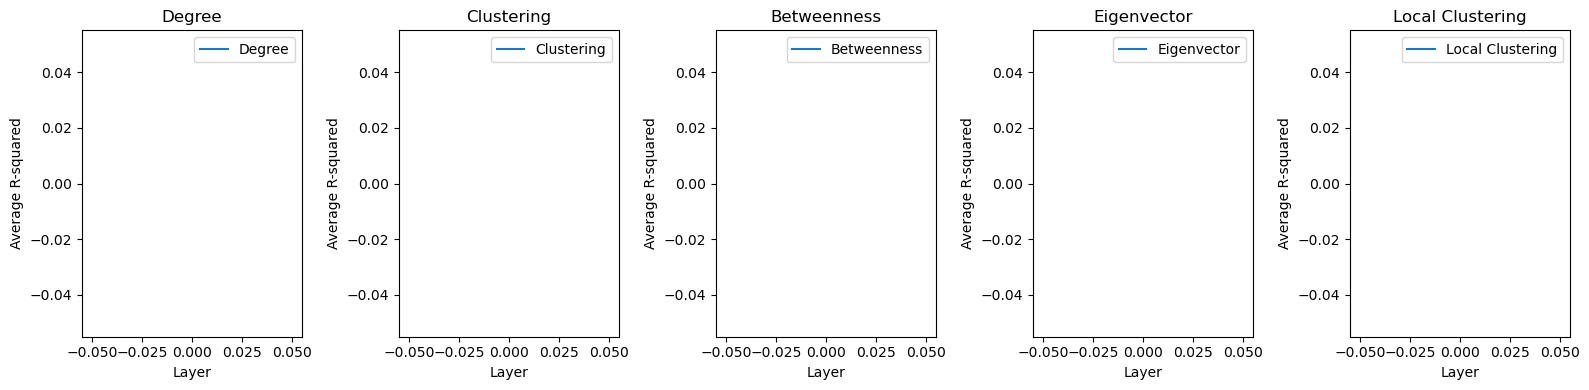

In [57]:
# Find the top 3 nodes for each property
top_nodes = find_top_nodes(train_node_properties[0])
print("Top nodes:")
for property_idx, node_idxs in enumerate(top_nodes):
    print(f"{['Degree', 'Clustering', 'Betweenness', 'Eigenvector', 'Local Clustering'][property_idx]}: {node_idxs}")

# Probe the top nodes
probe_top_nodes(train_features, train_node_properties)

# Probe all nodes
r2_scores = probe_all_nodes(train_features, train_node_properties)

# Visualize the relationship between property values and prediction scores
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, ax in enumerate(axs):
    ax.plot(range(4), r2_scores, label=['Degree', 'Clustering', 'Betweenness', 'Eigenvector', 'Local Clustering'][i])
    ax.set_title(['Degree', 'Clustering', 'Betweenness', 'Eigenvector', 'Local Clustering'][i])
    ax.set_xlabel('Layer')
    ax.set_ylabel('Average R-squared')
    ax.legend()

plt.tight_layout()
plt.show()

##### try bis

In [50]:
#we have 8 features, the first 4 are the node-level properties, the last 4 are the node embeddings
#we will use the node embeddings to predict the node-level properties

# Train and test features are lists of lists. Each element correspond to a graph, each graph has 8 layers of features, and each features has a shape of (num_nodes, num_features) where each row is a node and each column is a feature. 
# As a consequence the number of nodes in the graph is changing for each graph, so we have to pad the features to have the same number of nodes for each graph

# Define a function to pad the features
def pad_features(features, max_nodes):
    padded_features = []
    for graph_features in features:
        # Convert graph_features to torch tensors if they are numpy arrays
        graph_features = [torch.tensor(graph_feature) if isinstance(graph_feature, np.ndarray) else graph_feature for graph_feature in graph_features]
        
        num_nodes = graph_features[0].shape[0]
        padding = max_nodes - num_nodes
        padding_tensor = torch.zeros(padding, graph_features[0].shape[1])
        padded_features.append([torch.cat([graph_feature, padding_tensor], dim=0) for graph_feature in graph_features])
    return padded_features

# Compute the maximum number of nodes in the dataset
max_nodes = max([graph.num_nodes for graph in gnn.dataset[gnn.train_idx]])

# Pad the features
train_features_padded = pad_features(train_features, max_nodes)
test_features_padded = pad_features(test_features, max_nodes)

# Check the shape of the first graph's padded features
for i, feature in enumerate(train_features_padded[0]):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: torch.Size([29, 60])
Feature 2 shape: torch.Size([29, 60])
Feature 3 shape: torch.Size([29, 60])
Feature 4 shape: torch.Size([29, 60])


In [ ]:
#same with node properties

In [ ]:
for i, feature in enumerate(node[0]):
    print(f"Feature {i+1} shape:", feature.shape)

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you've already defined LinearModel class and computed node properties

# Define property names and embeddings
property_names = ['degree', 'clustering_coefficient', 'centrality']
embeddings = train_features  # Assuming train_features is a list of embeddings for each layer
test_embeddings = test_features  # Assuming test_features is a list of embeddings for each layer
embeddings_names = ['x1', 'x2', 'x3', 'x4']

# Create a dictionary to store the results
results = {}

for ii, (train_embedding, test_embedding) in enumerate(zip(embeddings, test_embeddings)):
    # Convert list of embeddings to a single numpy array
    train_embedding = np.concatenate(train_embedding)
    test_embedding = np.concatenate(test_embedding)
    
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, 1)  # Predicting one property at a time
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 1000  # Adjust as needed

        # Convert to PyTorch tensors
        train_X = torch.FloatTensor(train_embedding)
        train_y = torch.FloatTensor(train_node_properties)[:, i].unsqueeze(1)
        test_X = torch.FloatTensor(test_embedding)
        test_y = torch.FloatTensor(test_node_properties)[:, i].unsqueeze(1)

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_X)
            loss = criterion(outputs, train_y)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 100 == 0:  # Adjust for desired print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Embedding: {embeddings_names[ii]}, Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_X).cpu().numpy()
            test_pred = model(test_X).cpu().numpy()

            train_mse = mean_squared_error(train_y.cpu().numpy(), train_pred)
            test_mse = mean_squared_error(test_y.cpu().numpy(), test_pred)

            train_r2 = r2_score(train_y.cpu().numpy(), train_pred)
            test_r2 = r2_score(test_y.cpu().numpy(), test_pred)

            print(f'Embedding: {embeddings_names[ii]}, Shape: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            # Add the results to the dictionary
            results[(embeddings_names[ii], property_name)] = (train_mse, test_mse, train_r2, test_r2)

# Print summary of results
print("\nSummary of Results:")
for (embedding, property_name), (train_mse, test_mse, train_r2, test_r2) in results.items():
    print(f"Embedding: {embedding}, Property: {property_name}")
    print(f"  Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}")
    print()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_13496\2996269044.py", line 33, in <module>
    train_y = torch.FloatTensor(train_node_properties)[:, i].unsqueeze(1)
ValueError: expected sequence of length 25 at dim 2 (got 27)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structur

Test avec concatenate

In [ ]:
train_x2.shape

In [ ]:
# Concatenate properties with embeddings
def concatenate_embeddings_with_properties(node_embeddings, node_properties):
    concatenated_features = []
    for embeddings, properties in zip(node_embeddings, node_properties):
        combined = [np.concatenate((embedding, np.array(property))) for embedding, property in zip(embeddings, zip(*properties))]
        concatenated_features.append(combined)
    return concatenated_features

train_combined_features = concatenate_embeddings_with_properties(train_x2, train_node_properties)
test_combined_features = concatenate_embeddings_with_properties(test_x2, test_node_properties)


test avec extend() and flatten

Here we use padding in order to flatten the inconsistent of train_node_properties_flat and test_node_properties_flat. 

In [ ]:
import numpy as np
import torch

# Padding and Masking for Consistency
def pad_sequences(sequences, pad_value=0):
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        padded_seq = np.pad(seq, (0, max_length - len(seq)), 'constant', constant_values=pad_value)
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

# Pad node embeddings
train_x_padded = pad_sequences(train_features)
test_x_padded = pad_sequences(test_features)

# Pad node properties
train_y_padded = pad_sequences(train_node_properties)
test_y_padded = pad_sequences(test_node_properties)

# Convert to PyTorch tensors
train_x_tensor = torch.tensor(train_x_padded, dtype=torch.float32)
test_x_tensor = torch.tensor(test_x_padded, dtype=torch.float32)

train_y_tensor = torch.tensor(train_y_padded, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y_padded, dtype=torch.float32)


In [ ]:
#print the lendgth of the elements of train_node_properties_flat

for i in range(len(train_node_properties_flat)):
    print(len(train_node_properties_flat[i]))

Try the diag

In [37]:
# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

# Convert properties to tensors
train_y_node = torch.tensor(train_node_properties, dtype=torch.float32)
test_y_node = torch.tensor(test_node_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['degree', 'clustering_coeff', 'betweenness_centrality', 'eigenvector_centrality', 'local_clustering_coeff']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4)]
embeddings_names = ['x', 'x2', 'x3', 'x4']

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_13496\155743087.py", line 2, in <module>
    train_x = np.array([feat[0] for feat in train_features])
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1600,) + inhomogeneous part.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-p

#### Diagnostic classifier

In [ ]:
# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x_global = np.array([feat[4] for feat in train_features])
test_x_global = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

# train_y_node = torch.tensor(train_node_properties, dtype=torch.float32)
# test_y_node = torch.tensor(test_node_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']

In [ ]:
#compare train_node_properties and train_propertiesn their length
print(train_node_properties[0])
print(train_properties[0])

print(len(train_node_properties), len(train_properties))

In [ ]:
train_y_node = torch.tensor(train_node_properties, dtype=torch.float32)

In [48]:
#check the length of the embeddings for train_x, test_x, train_x2, test_x2, train_x3, test_x3, train_x4, test_x4
len(train_x), len(test_x), len(train_x2), len(test_x2), len(train_x3), len(test_x3), len(train_x4), len(test_x4)

(6400, 1600, 6400, 1600, 6400, 1600, 6400, 1600)

In [ ]:
train_x = np.array([feat[0] for feat in train_features])

print(len(train_x))
print(train_x[0])
print(train_x[0].shape)

In [ ]:
#pritn the distribution of the number of elements per embeddings in train_x
elements = [len(feat) for feat in train_x2]
plt.hist(elements, bins=range(0, max(elements)+1, 1), alpha=0.75, rwidth=0.85, color='b', edgecolor='black')
plt.xlabel('Number of elements')
plt.ylabel('Frequency')
plt.title('Number of elements per embeddings in train_x')
plt.show()

#print the min and max number of elements in the embeddings in train_x
min(elements), max(elements), len(elements)

In [ ]:
# Flatten node properties into a single list for training
train_node_degrees = np.concatenate([props[0] for props in train_node_properties])
train_clustering_coeffs = np.concatenate([props[1] for props in train_node_properties])
train_betweenness_centralities = np.concatenate([props[2] for props in train_node_properties])

test_node_degrees = np.concatenate([props[0] for props in test_node_properties])
test_clustering_coeffs = np.concatenate([props[1] for props in test_node_properties])
test_betweenness_centralities = np.concatenate([props[2] for props in test_node_properties])

# Convert node properties to PyTorch tensors
train_y_degrees = torch.tensor(train_node_degrees, dtype=torch.float32)
train_y_clustering = torch.tensor(train_clustering_coeffs, dtype=torch.float32)
train_y_betweenness = torch.tensor(train_betweenness_centralities, dtype=torch.float32)

test_y_degrees = torch.tensor(test_node_degrees, dtype=torch.float32)
test_y_clustering = torch.tensor(test_clustering_coeffs, dtype=torch.float32)
test_y_betweenness = torch.tensor(test_betweenness_centralities, dtype=torch.float32)

# Define node properties names and graph properties names
node_properties_names = ['node_degrees', 'clustering_coeffs', 'betweenness_centralities']
embeddings_for_node_properties = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4)]

In [ ]:
# Define the node property tensors for training and testing
train_y_list = [train_y_degrees, train_y_clustering, train_y_betweenness]
test_y_list = [test_y_degrees, test_y_clustering, test_y_betweenness]

# Train and evaluate model for node-level properties
for train_embedding, test_embedding in embeddings_for_node_properties:
    input_size = train_embedding.shape[2]  # Since train_embedding is 3D: [num_graphs, num_nodes, embedding_dim]

    for i, property_name in enumerate(node_properties_names):
        model = LinearModel(input_size, output_size=1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 100  # Adjust this as needed

        train_y = train_y_list[i]
        test_y = test_y_list[i]

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            # Flatten the embeddings and the targets to handle as a batch
            train_embedding_flat = train_embedding.view(-1, input_size)
            train_y_flat = train_y.view(-1)

            outputs = model(train_embedding_flat).squeeze()
            target = train_y_flat.squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_embedding_flat = test_embedding.view(-1, input_size)
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y_flat.cpu().numpy()
            test_target = test_y.view(-1).cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Node Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


In [ ]:
node_properties = ['node_degrees', 'clustering_coeffs', 'betweenness_centralities']
node_y_train = [train_y_degrees, train_y_clustering, train_y_betweenness]
node_y_test = [test_y_degrees, test_y_clustering, test_y_betweenness]

embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4)]
embeddings_names = ['x', 'x2', 'x3', 'x4']

for embedding_name, (train_embedding, test_embedding) in zip(embeddings_names, embeddings):
    input_size = train_embedding.shape[1]

    for property_name, train_y, test_y in zip(node_properties, node_y_train, node_y_test):
        model = LinearModel(input_size, 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 100  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y.squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Embedding: {embedding_name}, Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y.cpu().numpy()
            test_target = test_y.cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding_name}, Node Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


In [ ]:
# Extract node-level embeddings
# This example assumes the node-level embeddings are already extracted
# and the train_node_properties and test_node_properties are computed as before

# Flatten node properties into a single list for training
train_node_degrees = np.concatenate([props[0] for props in train_node_properties])
train_clustering_coeffs = np.concatenate([props[1] for props in train_node_properties])
train_betweenness_centralities = np.concatenate([props[2] for props in train_node_properties])

test_node_degrees = np.concatenate([props[0] for props in test_node_properties])
test_clustering_coeffs = np.concatenate([props[1] for props in test_node_properties])
test_betweenness_centralities = np.concatenate([props[2] for props in test_node_properties])

# Convert node properties to PyTorch tensors
train_y_degrees = torch.tensor(train_node_degrees, dtype=torch.float32)
train_y_clustering = torch.tensor(train_clustering_coeffs, dtype=torch.float32)
train_y_betweenness = torch.tensor(train_betweenness_centralities, dtype=torch.float32)

test_y_degrees = torch.tensor(test_node_degrees, dtype=torch.float32)
test_y_clustering = torch.tensor(test_clustering_coeffs, dtype=torch.float32)
test_y_betweenness = torch.tensor(test_betweenness_centralities, dtype=torch.float32)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

# Define the linear model for node-level properties
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

node_properties = ['node_degrees', 'clustering_coeffs', 'betweenness_centralities']
node_y_train = [train_y_degrees, train_y_clustering, train_y_betweenness]
node_y_test = [test_y_degrees, test_y_clustering, test_y_betweenness]

embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4)]
embeddings_names = ['x', 'x2', 'x3', 'x4']

for embedding_name, (train_embedding, test_embedding) in zip(embeddings_names, embeddings):
    input_size = train_embedding.shape[1]

    for property_name, train_y, test_y in zip(node_properties, node_y_train, node_y_test):
        model = LinearModel(input_size, 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 100  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y.squeeze()

            # Debugging information
            print(f"Epoch [{epoch+1}/{num_epochs}], Embedding: {embedding_name}, Property: {property_name}")
            print(f"outputs shape: {outputs.shape}, target shape: {target.shape}")

            if outputs.shape != target.shape:
                print(f"Shape mismatch: outputs shape {outputs.shape}, target shape {target.shape}")
                continue

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y.cpu().numpy()
            test_target = test_y.cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding_name}, Node Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


In [ ]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

In [ ]:


# Evaluate to get node-level features
train_node_features, test_node_features = gnn.evaluate_with_features()
